# Sentiment analysis of movie (IMDB) reviews 

using dataset provided by the ACL 2011 paper, see http://ai.stanford.edu/~amaas/data/sentiment/.

Dataset can be downloaded separately from http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz, but wont be necessary as the download process has been embedded in the notebook and source file.

### Table of Contents<a class="anchor" id="table"></a>
* [Data exploration](#data_e)
* [Modelling](#model)
    * [Compare vectorisation techniques](#compare)
    * [Logistic Regression](#logis)
        * [Logistic Regression with bag of word](#logis_bag)
        * [Logistic Regression with TFIDF](#logis_tfidf)
    * [Random Forest](#randfor)
        * [Random Forest with Hashing](#rand_for_bag)
        * [Random Forest with TFIDF](#rand_for_tfidf)
    * [Linear SVC](#linearsvc)
        * [Random Forest with Hashing](#linear_bag)
        * [Random Forest with TFIDF](#linear_tfidf)
* [Display scores for all trained models](#disp_sco)


In [1]:
# uncomment these for Google collab, will have already been installed in local environment 
# if 'pip install -r requirements.txt' has been run
#!pip install nltk
#!pip install --upgrade gensim

import numpy as np
import pandas as pd
import os
import os.path

from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
import nltk


import glob
from gensim.models import Word2Vec

import time

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /home/jeremie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
import pandas as pd
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import LinearSVC

In [3]:
import wget
import tarfile

# By checking if the directory exists first, we allow people to delete the tarfile without the notebook re-downloading it
if os.path.isdir('aclImdb'):
    print("Dataset directory exists, taking no action")
else:    
    if not os.path.isfile('aclImdb_v1.tar.gz'):
        print("Downloading dataset")
        #!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
        wget.download('http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz')
    else:
        print("Dataset already downloaded")
    
    print("Unpacking dataset")
    #!tar -xf aclImdb_v1.tar.gz 
    tar = tarfile.open("aclImdb_v1.tar.gz")
    tar.extractall()
    tar.close()
    print("Dataset unpacked in aclImdb")

import re

# load doc into memory
# regex to clean markup elements 
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r', encoding='utf8')
    # read all text
    text = re.sub('<[^>]*>', ' ', file.read())
    #text = file.read()
    # close the file
    file.close()
    return text

Dataset directory exists, taking no action


In [4]:
# notebook configuration
# SAMPLE_SIZE=12500
SAMPLE_SIZE=50000
# SAMPLE_SIZE=1000
# TRAIN_TEST_RATIO=0.75
TRAIN_TEST_RATIO=0.50
TRAINING_SET_SIZE=int(SAMPLE_SIZE * (1 - TRAIN_TEST_RATIO))
VALIDATION_SET_SIZE=int(SAMPLE_SIZE * TRAIN_TEST_RATIO)

In [5]:
dataframes={}
for type in ["train","test"]:
    if type=="train":
        SLICE = int(TRAINING_SET_SIZE / 2)
    elif type=="test":
        SLICE = int(VALIDATION_SET_SIZE / 2)

    positive_file_list = glob.glob(os.path.join('aclImdb/'+type+'/pos', "*.txt"))
    positive_sample_file_list = positive_file_list[:SLICE]
    df_positive = pd.DataFrame({'reviews':[load_doc(x) for x in positive_sample_file_list], 'sentiment': np.ones(SLICE)})
    
    negative_file_list = glob.glob(os.path.join('aclImdb/'+type+'/neg', "*.txt"))
    negative_sample_file_list = negative_file_list[:SLICE]
    df_negative = pd.DataFrame({'reviews':[load_doc(x) for x in negative_sample_file_list], 'sentiment': np.zeros(SLICE)})

    dataframes[type]=pd.concat([df_positive,df_negative])
    dataframes[type]=shuffle(dataframes[type])

df=pd.concat([dataframes["train"],dataframes["test"]])
    
X_train=dataframes["train"]['reviews']
y_train=dataframes["train"]['sentiment']

X_test=dataframes["test"]['reviews']
y_test=dataframes["test"]['sentiment']

In [6]:
print(X_train.shape)
print(X_test.shape)
print(y_train.unique())

(25000,)
(25000,)
[1. 0.]


<a href='#table'>Back</a>
# Modelling <a class="anchor" id="model"></a> 

We have decided to do the use the below models and vectorisation techniques to test our their accuracy / score, the idea is to use a one model and one vectorization technique and plot a score.

**Vectorisation techniques**
- Bag of Words
- TFIDF (weighted bag of words) http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
- mapping words to plain integers
- mapping words to embedding vectors


**Simple models**

- Logistic Regression
- Random Forst
- LSTM
- GRU
- CNN

**Embeddings to try**
- Word2Vec
- FastText
- Glove

**APIs we used**
- Introducing Pipeline: http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
- Introducing cross_val_score http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

## Compare vectorisation techniques<a class="anchor" id="compare"></a> 

In [7]:
CountVec = CountVectorizer()
# Creating the BoW with the set of all the documents and transforming the documents in feature vectors
bag_of_words=CountVec.fit_transform(df['reviews'])
bag_of_words

<50000x101888 sparse matrix of type '<class 'numpy.int64'>'
	with 6797241 stored elements in Compressed Sparse Row format>

In [8]:
hashing = HashingVectorizer(strip_accents='ascii', lowercase=True, preprocessor=None,n_features=bag_of_words.shape[1])
reviews_hashing=hashing.fit_transform(df['reviews'])
reviews_hashing

<50000x101888 sparse matrix of type '<class 'numpy.float64'>'
	with 6793600 stored elements in Compressed Sparse Row format>

In [9]:
tfidf = TfidfVectorizer(strip_accents='ascii', lowercase=True, preprocessor=None,max_features=bag_of_words.shape[1])
reviews_tfidf=tfidf.fit_transform(df['reviews'])
reviews_tfidf

<50000x101888 sparse matrix of type '<class 'numpy.float64'>'
	with 6797188 stored elements in Compressed Sparse Row format>

In [10]:
results=pd.DataFrame()

## Logistic Regression <a class="anchor" id="logis"></a> 


### Logistic Regress model using Bag of Words vectorisation technique<a class="anchor" id="logis_bag"></a> 

In [11]:
time_beginning_of_training = time.time()

model=LogisticRegression(random_state=0)
model.fit(hashing.fit_transform(X_train), y_train)
train_acc=model.score(hashing.transform(X_train), y_train)
print('Train accuracy {}'.format(train_acc))
test_acc=model.score(hashing.transform(X_test), y_test)
print('Test accuracy {}'.format(test_acc))

time_end_of_training = time.time()
print('Time to run: {}'.format(time_end_of_training-time_beginning_of_training))

Train accuracy 0.88008
Test accuracy 0.85996
Time to run: 15.24264931678772


In [12]:
df = pd.DataFrame({})
df.reset_index(inplace=True)
df["title"]=["log reg Hashing"]
df["sample_size"]=[SAMPLE_SIZE]
df["acc"]=train_acc
df["val_acc"]=test_acc
df.drop(labels="index",axis=1,inplace=True)
print(df)
results=pd.concat([df,results])

             title  sample_size      acc  val_acc
0  log reg Hashing        50000  0.88008  0.85996


### Logistic Regress model using TfidfVectorizer vectorisation technique<a class="anchor" id="logis_tfidf"></a> 

In [13]:
time_beginning_of_training = time.time()

model=LogisticRegression(random_state=0)
model.fit(tfidf.fit_transform(X_train), y_train)
train_acc=model.score(tfidf.transform(X_train), y_train)
print('Train accuracy {}'.format(train_acc))
test_acc=model.score(tfidf.transform(X_test), y_test)
print('Test accuracy {}'.format(test_acc))

time_end_of_training = time.time()
print('Time to run: {}'.format(time_end_of_training-time_beginning_of_training))


Train accuracy 0.9332
Test accuracy 0.883
Time to run: 18.888742208480835


In [14]:
df = pd.DataFrame({})
df.reset_index(inplace=True)
df["title"]=["log reg Tfidf"]
df["sample_size"]=[SAMPLE_SIZE]
df["acc"]=train_acc
df["val_acc"]=test_acc
df.drop(labels="index",axis=1,inplace=True)
print(df)
results=pd.concat([df,results])

           title  sample_size     acc  val_acc
0  log reg Tfidf        50000  0.9332    0.883


## RandomForestClassifer<a class="anchor" id="rand_for"></a> 

### RandomForestClassifer with hashing<a class="anchor" id="rand_for_bag"></a>

In [15]:
time_beginning_of_training = time.time()

model=RandomForestClassifier(random_state=0)
model.fit(hashing.fit_transform(X_train), y_train)
train_acc=model.score(hashing.transform(X_train), y_train)
print('Train accuracy {}'.format(train_acc))
test_acc=model.score(hashing.transform(X_test), y_test)
print('Test accuracy {}'.format(test_acc))

time_end_of_training = time.time()
print('Time to run: {}'.format(time_end_of_training-time_beginning_of_training))


Train accuracy 0.9938
Test accuracy 0.72992
Time to run: 26.840269565582275


In [16]:
df = pd.DataFrame({})
df.reset_index(inplace=True)
df["title"]=["Rand for hashing"]
df["sample_size"]=[SAMPLE_SIZE]
df["acc"]=train_acc
df["val_acc"]=test_acc
df.drop(labels="index",axis=1,inplace=True)
print(df)
results=pd.concat([df,results])

              title  sample_size     acc  val_acc
0  Rand for hashing        50000  0.9938  0.72992


### RandomForestClassifer with TFIDF<a class="anchor" id="rand_for_tfidf"></a>

In [17]:
time_beginning_of_training = time.time()

model=RandomForestClassifier(random_state=0)
model.fit(tfidf.fit_transform(X_train), y_train)
train_acc=model.score(tfidf.transform(X_train), y_train)
print('Train accuracy {}'.format(train_acc))
test_acc=model.score(tfidf.transform(X_test), y_test)
print('Test accuracy {}'.format(test_acc))

time_end_of_training = time.time()
print('Time to run: {}'.format(time_end_of_training-time_beginning_of_training))


Train accuracy 0.99372
Test accuracy 0.73068
Time to run: 29.24355149269104


In [18]:
df = pd.DataFrame({})
df.reset_index(inplace=True)
df["title"]=["Rand for tfidf"]
df["sample_size"]=[SAMPLE_SIZE]
df["acc"]=train_acc
df["val_acc"]=test_acc
df.drop(labels="index",axis=1,inplace=True)
print(df)
results=pd.concat([df,results])

            title  sample_size      acc  val_acc
0  Rand for tfidf        50000  0.99372  0.73068


## Linear SVC <a class="anchor" id="linearsvc"></a> 

### Linear SVC with hashing<a class="anchor" id="linear_bag"></a>

In [19]:
time_beginning_of_training = time.time()

model=LinearSVC(random_state=0)
model.fit(hashing.fit_transform(X_train), y_train)
train_acc=model.score(hashing.transform(X_train), y_train)
print('Train accuracy {}'.format(train_acc))
test_acc=model.score(hashing.transform(X_test), y_test)
print('Test accuracy {}'.format(test_acc))

time_end_of_training = time.time()
print('Time to run: {}'.format(time_end_of_training-time_beginning_of_training))


Train accuracy 0.9408
Test accuracy 0.88344
Time to run: 13.465518712997437


In [20]:
df = pd.DataFrame({})
df.reset_index(inplace=True)
df["title"]=["LinearSVC hashing"]
df["sample_size"]=[SAMPLE_SIZE]
df["acc"]=train_acc
df["val_acc"]=test_acc
df.drop(labels="index",axis=1,inplace=True)
print(df)
results=pd.concat([df,results])

               title  sample_size     acc  val_acc
0  LinearSVC hashing        50000  0.9408  0.88344


### Linear SVC with TFIDF<a class="anchor" id="linearsvc_tfidf"></a>

In [21]:
time_beginning_of_training = time.time()

model=LinearSVC(random_state=0)
model.fit(tfidf.fit_transform(X_train), y_train)
train_acc=model.score(tfidf.transform(X_train), y_train)
print('Train accuracy {}'.format(train_acc))
test_acc=model.score(tfidf.transform(X_test), y_test)
print('Test accuracy {}'.format(test_acc))

time_end_of_training = time.time()
print('Time to run: {}'.format(time_end_of_training-time_beginning_of_training))


Train accuracy 0.99008
Test accuracy 0.87716
Time to run: 17.10219168663025


In [22]:
df = pd.DataFrame({})
df.reset_index(inplace=True)
df["title"]=["LinearSVC tfidf"]
df["sample_size"]=[SAMPLE_SIZE]
df["acc"]=train_acc
df["val_acc"]=test_acc
df.drop(labels="index",axis=1,inplace=True)
print(df)
results=pd.concat([df,results])

             title  sample_size      acc  val_acc
0  LinearSVC tfidf        50000  0.99008  0.87716


# Display scores for all trained models<a class="anchor" id="disp_sco"></a>

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


In [24]:
# acc	batch_size	categorical_accuracy	loss	nb_epochs	sample_size	title	title_short	train_acc	train_test_ratio	training_duration_in_secs	training_set_size	val_acc	val_categorical_accuracy	val_loss	validation_set_size	vocab_size

results

,title,sample_size,acc,val_acc
0,LinearSVC tfidf,50000,0.99008,0.87716
0,LinearSVC hashing,50000,0.94080,0.88344
0,Rand for tfidf,50000,0.99372,0.73068
0,Rand for hashing,50000,0.99380,0.72992
0,log reg Tfidf,50000,0.93320,0.88300
0,log reg Hashing,50000,0.88008,0.85996


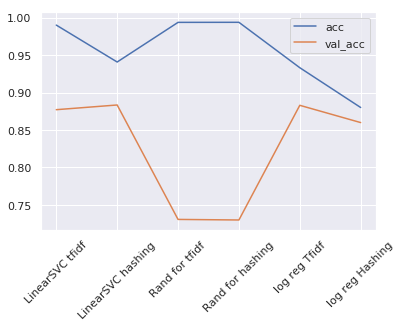

In [25]:
plt.plot(results.title,results.acc)
plt.plot(results.title,results.val_acc)
plt.rcParams["figure.figsize"] = [17,2]
plt.xticks(rotation=45)
plt.legend()

In [26]:

results.to_csv(path_or_buf="reports/simple_ml_models.csv")